# Classfication

## Load and setup data

In [51]:
import os
import sqlalchemy
import pandas as pd
from pathlib import Path
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
#print(os.getcwd())

In [52]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/gdc.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select d.*, c.*,\
  case\
   when age_at_diagnosis_years <18 then 'Under 18'\
   when age_at_diagnosis_years between 18 and 24 then '18 - 24'\
   when age_at_diagnosis_years between 25 and 34 then '25 - 34'\
   when age_at_diagnosis_years between 35 and 44 then '35 - 44'\
   when age_at_diagnosis_years between 45 and 54 then '45 - 54'\
   when age_at_diagnosis_years between 55 and 64 then '55 - 64'\
   when age_at_diagnosis_years >= 65 then '65 or older'\
 END as age_range,\
 CASE \
 	when c.\"gene.SIM1\" = '1' or c.\"gene.POMC\" = 1 or c.\"gene.LEPR\" ='1' or c.\"gene.MRAP2\" = 1 or c.\"gene.ADCY3\" = 1 or c.\"gene.NTRK2\" = 1 or c.\"gene.MC4R\"  = 1 or c.\"gene.KSR2\" = 1 or c.\"gene.LEP\" = 1 or c.\"gene.PCSK1\" = 1 or c.\"gene.BDNF\"  =1 or c.\"gene.SH2B1\" = 1 then TRUE \
 	ELSE FALSE \
 END as obesity_mutation,\
 (c.\"gene.SIM1\" + c.\"gene.POMC\" + c.\"gene.LEPR\" + c.\"gene.MRAP2\" + c.\"gene.ADCY3\" + c.\"gene.NTRK2\" + c.\"gene.MC4R\" + c.\"gene.KSR2\" + c.\"gene.LEP\" + c.\"gene.PCSK1\" + c.\"gene.BDNF\" + c.\"gene.SH2B1\") as obesity_mutation_count\
 from diagnoses d, cases c\
 where d.case_id = c.id  and year_of_diagnosis = '2011' and year_of_diagnosis is not null;"
    gdc = pd.read_sql_query(sqlstatement_obese, conn)
    gdc['year_of_diagnosis'] = gdc['year_of_diagnosis'].astype(int)

In [53]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like '%aged 18 years and older who have obesity' and YearStart = 2011 order by StratificationID1;"
    brfss_obesity = pd.read_sql_query(sqlstatement_obese, conn)
    brfss_obesity['Data_Value'] = brfss_obesity['Data_Value'].astype("float")

In [54]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_overweight = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults aged 18 years and older who have an overweight classification' and YearStart = 2011 order by StratificationID1;"
    brfss_overweight = pd.read_sql_query(sqlstatement_overweight, conn)
    brfss_overweight['Data_Value'] = brfss_overweight['Data_Value'].astype("float")

In [55]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_nophyac = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults who engage in no leisure-time physical activity' and YearStart = 2011 order by StratificationID1;"
    brfss_nophyac = pd.read_sql_query(sqlstatement_nophyac, conn)
    brfss_nophyac['Data_Value'] = brfss_nophyac['Data_Value'].astype("float")

In [56]:
dbEngine=sqlalchemy.create_engine('sqlite:///../../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_musclestr2ormore = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week' and YearStart = 2011 order by StratificationID1;"
    brfss_musclestr2ormore = pd.read_sql_query(sqlstatement_musclestr2ormore, conn)
    brfss_musclestr2ormore['Data_Value'] = brfss_musclestr2ormore['Data_Value'].astype("float")

In [57]:
brfss_gdc = gdc

def obesity_prob(age_group):
    ob_lines = brfss_obesity.loc[brfss_obesity['Age(years)'] == age_group]
    ob_line = ob_lines.iloc[0]
    return ob_line['Data_Value']

def overweight_prob(age_group):
    lines = brfss_overweight.loc[brfss_overweight['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

def nophyac_prob(age_group):
    lines = brfss_nophyac.loc[brfss_nophyac['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

def musclestr2ormore_prob(age_group):
    lines = brfss_musclestr2ormore.loc[brfss_musclestr2ormore['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

brfss_gdc['obesity_prob'] = brfss_gdc['age_range'].map(obesity_prob)
brfss_gdc['overweight_prob'] = brfss_gdc['age_range'].map(overweight_prob)
brfss_gdc['nophyac_prob'] = brfss_gdc['age_range'].map(nophyac_prob)
brfss_gdc['musclestr2ormore_prob'] = brfss_gdc['age_range'].map(musclestr2ormore_prob)

In [58]:
xdf = pd.DataFrame(brfss_gdc, columns=['age_at_diagnosis_days', 'primary_site', 'disease_type', 'obesity_prob', 'overweight_prob', 'nophyac_prob', 'musclestr2ormore_prob'])

#https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def onehotEncoding(orig, feature):
    one_hot = pd.get_dummies(xdf[[feature]])
    res = pd.concat([xdf, one_hot], axis=1)
    return(res)

xdf = onehotEncoding(xdf, 'primary_site')
xdf = onehotEncoding(xdf, 'disease_type')
xdf.pop('primary_site')
xdf.pop('disease_type');

In [59]:
#Split dataset into train, validation and test
#https://realpython.com/train-test-split-python-data/
#https://blog.roboflow.com/train-test-split/
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test#38251213
y = brfss_gdc['obesity_mutation']

x_train, x_temp, y_train, y_temp = train_test_split(xdf, y, random_state=42, train_size=.7, test_size=.3)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, random_state=42, train_size=2/3, test_size=1/3)

In [60]:
#Logistic regression
# LR = LogisticRegression(random_state=42, solver='lbfgs', multi_class='ovr').fit(x_train, y_train)
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(x_train, y_train);

In [61]:
#Validation
prediction = logreg.predict(x_validation)
print(classification_report(y_validation, prediction))

              precision    recall  f1-score   support

           0       0.90      0.47      0.62        81
           1       0.85      0.98      0.91       249

    accuracy                           0.86       330
   macro avg       0.88      0.73      0.77       330
weighted avg       0.86      0.86      0.84       330



Interpretation of the classification report: https://www.statology.org/sklearn-classification-report/

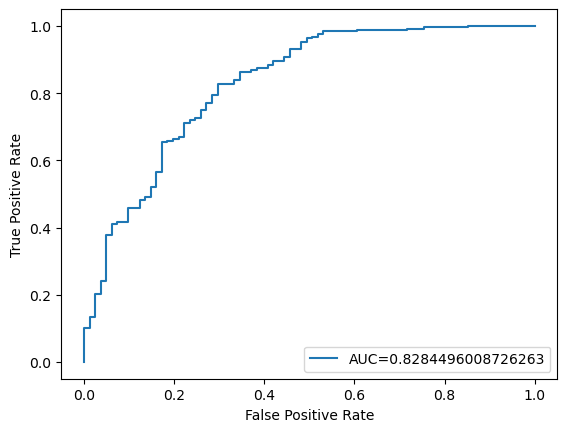

In [62]:
y_pred_proba = logreg.predict_proba(x_validation)[::,1]
fpr, tpr, _ = roc_curve(y_validation,  y_pred_proba)
auc = roc_auc_score(y_validation, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()